# Axora: Clinical Document Classification
## Notebook 2: Classification Modeling & Evaluation

---

## 🔹 Executive Summary
This notebook is the **second stage** of the project, focusing on **supervised classification modeling**.  
Building upon the preprocessed data from Notebook 1, we implement and evaluate a **Softmax Regression model (Multinomial Logistic Regression)** to automatically classify clinical documents into medical specialties.

## 📌 Purpose of this Notebook
- Train a baseline classification model using TF–IDF features.  
- Optimize hyperparameters with **GridSearchCV**.  
- Perform **cross-validation** to ensure stability.  
- Evaluate model performance with accuracy, precision, recall, F1-score, and confusion matrix.  
- Visualize **ROC–AUC curves** for multi-class evaluation.  
- Save the final model artifact for later deployment.  

This stage demonstrates the feasibility of automating document routing with a supervised learning approach.


## 📚 Importing Required Libraries

In this step, we import all the necessary Python libraries for data manipulation, visualization, modeling, 
and evaluation:

- **NumPy & Pandas** → numerical computations and data handling.  
- **Matplotlib & Seaborn** → data visualization.  
- **SciPy (sparse)** → loading sparse matrices (TF–IDF features).  
- **Scikit-learn** → logistic regression, cross-validation, hyperparameter tuning, and performance metrics.  
- **LogisticRegression** for Softmax regression.
- **GridSearchCV & cross_val_score** for hyperparameter tuning and cross-validation.
- **Confusion Matrix & Classification Report** for evaluation.
- **Joblib** → saving the trained model for later use. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import load_npz

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, StandardScaler

# Save model
import joblib

## 📂 Loading Vectorized Features and Labels

We load the **TF–IDF feature matrices** and their corresponding **labels** for training, validation, and testing.  
- The features are stored in sparse `.npz` format.  
- The labels are stored in `.csv` files.  

We then print the shapes of all datasets to confirm correct loading.
We load the preprocessed TF-IDF features (`train`, `val`, `test`) and their corresponding labels (`medical_specialty`).  
This ensures consistency with the preprocessing done in the previous notebook.


In [2]:
# Load TF-IDF features
X_train = load_npz("train_features_tfidf.npz")
X_val = load_npz("val_features_tfidf.npz")
X_test = load_npz("test_features_tfidf.npz")

# Load labels
y_train = pd.read_csv("train_labels.csv")['medical_specialty']
y_val = pd.read_csv("val_labels.csv")['medical_specialty']
y_test = pd.read_csv("test_labels.csv")['medical_specialty']

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes:
X_train: (1724, 5000) y_train: (1724,)
X_val: (370, 5000) y_val: (370,)
X_test: (370, 5000) y_test: (370,)


## 🔎 Training Softmax Regression (Multinomial Logistic Regression)

We use **multinomial Logistic Regression (Softmax Regression)** for multi-class classification.  
We define a multinomial Logistic Regression model with **lbfgs solver** and **max_iter=500**.  
A parameter grid is specified to tune the regularization strength `C`.
To optimize the model, we perform **Grid Search with Cross-Validation** over different values of the 
regularization parameter **C**.  

- `C`: Controls the strength of regularization.  
- `penalty`: We restrict to `"l2"` since it's compatible with multinomial logistic regression.  
- `cv=5`: 5-fold cross-validation to evaluate each parameter set.  

Finally, we extract the **best parameters** and the corresponding model.


In [10]:
log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"]
}

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,   
    scoring="accuracy",
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters: {'C': 100, 'penalty': 'l2'}


## ✅ Cross-Validation Results

We evaluate the best logistic regression model using **3-fold cross-validation**:  
- Display accuracy scores from each fold.  
- Compute the mean accuracy across folds.  
- Visualize the distribution of accuracies with a **boxplot**.  

This helps us understand the stability of the model across different splits.

We run **cross-validation** to check how stable the model’s performance is across folds. 
 
Note: Currently 3-fold CV is used, but increasing to 5 or 10 folds would provide a more robust estimate.


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Pytho

Cross-Validation Scores: [0.78550725 0.78550725 0.75652174 0.77391304 0.7877907 ]
Mean CV Accuracy: 0.7778479946073474


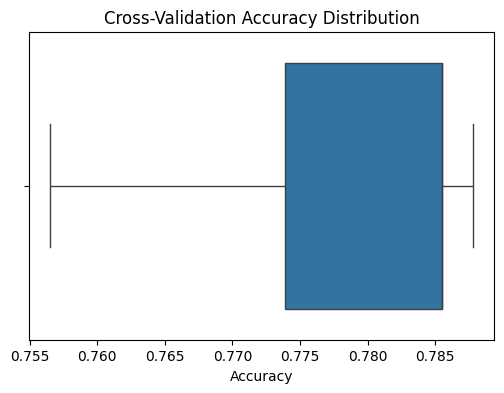

In [11]:
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring="accuracy")

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

plt.figure(figsize=(6,4))
sns.boxplot(x=cv_scores)
plt.title("Cross-Validation Accuracy Distribution")
plt.xlabel("Accuracy")
plt.show()


## 💾 Saving the Trained Model

### Saving the Trained Model
We save the best-performing model as `softmax_regression_model.pkl`.  
This artifact will later be packaged with preprocessing into a Scikit-learn Pipeline for deployment.


In [9]:
joblib.dump(best_model, "softmax_regression_model.pkl")
print("Model saved as softmax_regression_model.pkl")


Model saved as softmax_regression_model.pkl


## 📊 Model Evaluation on Test Data

We evaluate the model using:
- **Accuracy** (overall correctness)
- **Weighted Precision, Recall, and F1-score** (handles class imbalance)
- **Classification Report** (per-class performance)  
⚠️ Important: We must not only report metrics but also analyze their **business impact**.


In [12]:
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="weighted"))
print("Recall:", recall_score(y_test, y_pred, average="weighted"))
print("F1-score:", f1_score(y_test, y_pred, average="weighted"))

print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7756756756756756
Precision: 0.8056356092842579
Recall: 0.7756756756756756
F1-score: 0.784883734352827

Classification Report:
                             precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.93      0.95      0.94       109
      ENT - Otolaryngology       1.00      0.71      0.83        14
          Gastroenterology       0.92      0.83      0.87        41
     Hematology - Oncology       0.52      0.73      0.61        15
                Nephrology       1.00      0.50      0.67        10
                 Neurology       0.64      0.64      0.64        47
              Neurosurgery       0.41      0.45      0.43        20
   Obstetrics / Gynecology       0.93      0.78      0.85        32
             Ophthalmology       0.82      0.82      0.82        11
                Orthopedic       0.75      0.72      0.73        57
     Pediatrics - Neonatal       0.43      1.00      0.60         3
   Psychiatry / Psychology       0.75      0

## Per-Class Performance Analysis
We generate a **classification report** and convert it into a DataFrame for better readability.  
This allows us to:
- View **Precision, Recall, and F1-score** per specialty.  
- Identify the **lowest-performing specialties** by sorting on F1-score.  

This step is crucial for linking technical results back to the **business context**:  
low-performing specialties may indicate higher risk of misrouting clinical documents.


In [13]:
report = classification_report(y_test, y_pred, target_names=best_model.classes_, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df)

low_perf = report_df.sort_values("f1-score").head(3)
print("\nLowest Performing Specialties:\n", low_perf)


                            precision    recall  f1-score     support
Cardiovascular / Pulmonary   0.928571  0.954128  0.941176  109.000000
ENT - Otolaryngology         1.000000  0.714286  0.833333   14.000000
Gastroenterology             0.918919  0.829268  0.871795   41.000000
Hematology - Oncology        0.523810  0.733333  0.611111   15.000000
Nephrology                   1.000000  0.500000  0.666667   10.000000
Neurology                    0.638298  0.638298  0.638298   47.000000
Neurosurgery                 0.409091  0.450000  0.428571   20.000000
Obstetrics / Gynecology      0.925926  0.781250  0.847458   32.000000
Ophthalmology                0.818182  0.818182  0.818182   11.000000
Orthopedic                   0.745455  0.719298  0.732143   57.000000
Pediatrics - Neonatal        0.428571  1.000000  0.600000    3.000000
Psychiatry / Psychology      0.750000  0.666667  0.705882    9.000000
Radiology                    0.000000  0.000000  0.000000    2.000000
accuracy            

## 🔲 Confusion Matrix Heatmap

The confusion matrix shows how predictions are distributed across actual classes.  
This visualization helps identify:
- Which specialties are frequently confused with others.
- Whether some classes dominate predictions due to imbalance.  


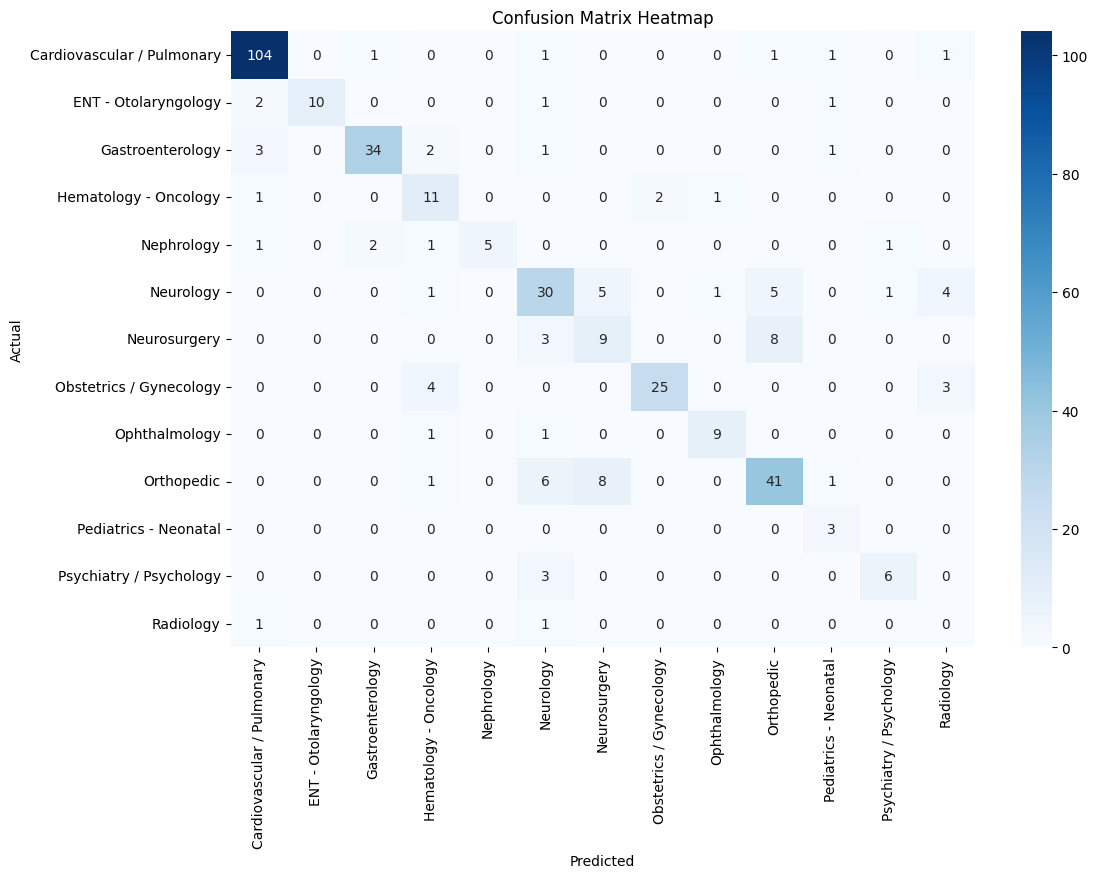

In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()


## 📈 Multi-class ROC Curve

We evaluate the **ROC–AUC performance** for each medical specialty class:  
- Binarize the true labels for multi-class ROC.  
- Predict class probabilities using the trained model.  
- Plot **ROC curves** and compute the **AUC score** for each class.  

We plot ROC curves and AUC for each specialty. 
 
This provides additional insights into **class separability**, but the main required metrics are Precision, Recall, and F1.


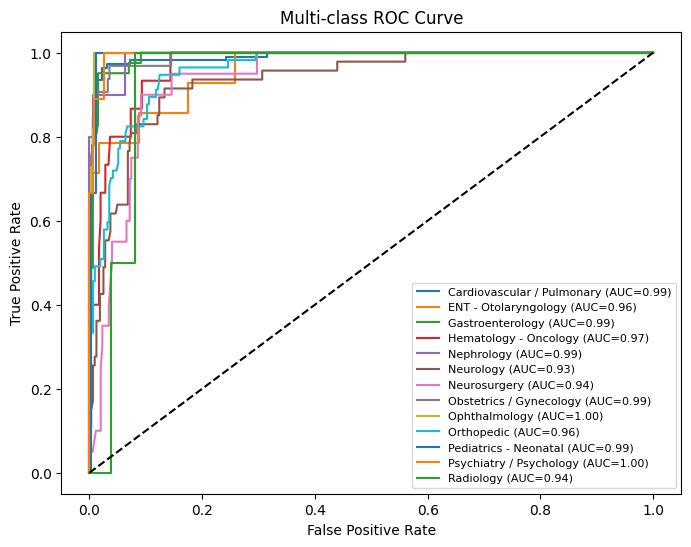

In [8]:
# Binarize labels
y_bin = label_binarize(y_test, classes=best_model.classes_)
n_classes = y_bin.shape[1]

# Predict probabilities
y_score = best_model.predict_proba(X_test)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{best_model.classes_[i]} (AUC={roc_auc[i]:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right", fontsize=8)
plt.show()


## Handling Class Imbalance with Weighted Logistic Regression
The dataset is likely imbalanced, with some specialties having far fewer samples.  
To address this, we retrain the Softmax Regression model using `class_weight="balanced"`.  

Key changes:
- Uses **weighted loss** so that minority classes contribute more to the objective.  
- Hyperparameter tuning is repeated with **f1_weighted** as the scoring metric.  
- Results are compared against the unbalanced model to check improvements for rare classes.


In [14]:
log_reg_balanced = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500,
    class_weight="balanced"
)

grid_search_bal = GridSearchCV(
    estimator=log_reg_balanced,
    param_grid=param_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

grid_search_bal.fit(X_train, y_train)
balanced_model = grid_search_bal.best_estimator_

print("Best Params (Balanced):", grid_search_bal.best_params_)

y_pred_bal = balanced_model.predict(X_test)
print("\nBalanced Classification Report:\n", classification_report(y_test, y_pred_bal))


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Params (Balanced): {'C': 1, 'penalty': 'l2'}

Balanced Classification Report:
                             precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.94      0.89      0.92       109
      ENT - Otolaryngology       0.75      0.64      0.69        14
          Gastroenterology       0.92      0.88      0.90        41
     Hematology - Oncology       0.45      0.67      0.54        15
                Nephrology       1.00      0.70      0.82        10
                 Neurology       0.64      0.64      0.64        47
              Neurosurgery       0.48      0.80      0.60        20
   Obstetrics / Gynecology       0.96      0.69      0.80        32
             Ophthalmology       0.80      0.73      0.76        11
                Orthopedic       0.88      0.63      0.73        57
     Pediatrics - Neonatal       0.30      1.00      0.46         3
   Psychiatry / Psychology       0.73      0.89      0.80         9
                 Radiology     

## Reloading Raw Text Data for Deployment Pipeline
To build a **deployment-ready Scikit-learn Pipeline**, we need the raw text data rather than only pre-vectorized features.  

We reload the dataset from Hugging Face and combine the **train and validation sets**.  
This provides:
- `texts_full` → list of medical transcriptions for fitting TF-IDF.  
- `labels_full` → corresponding medical specialties.  

This ensures the final pipeline can accept **new clinical text strings** at inference time.


In [15]:
from datasets import load_dataset

# Reload the original dataset from Hugging Face
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")

# Combine train + validation
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_full = pd.concat([df_train, df_val], ignore_index=True)

texts_full = df_full["transcription"].astype(str).tolist()
labels_full = df_full["medical_specialty"]


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Repo card metadata block was not found. Setting CardData to empty.
